In [1]:
"""
    使用XGBoost， 采用五折交叉验证
    MAE = 497
    
    模型融合：
    1）相同模型下的多个子模型，比如都用 XGBoost,采用5个子模型进行融合
    2）不同模型的融合，比如XGBoost + LightGBM 
    
    模型融合 不是在模型内进行融合
    而是对于模型的预测结果可进行加权平均（即融合）
    有几个模型，就有几个模型预测的结果
    然后对 预测结果 ，进行加权平均（相加/5)
    
    什么情况下模型融合不好？
    1） 与一个坏的模型进行融合 ： X MAE = 1000, XGBoost = 509 一起融合
     MAE = MEAN ABSOLUTE ERROR
     
     518,521,530,513,580 => 497
""" 
"""
    Baseline:
    1) 确定模型：LightGBM 或者XGBoost
    2) 确定特征: 去掉时间（因为时间特征 还需要做特征处理），去掉一些明显没用的特征，比如 ID ，name
    剩下的特征，放到模型中进行训练
    
    怎么提升:
    1) 利用时间，creat_year
    2) 构造新特征，brand 特征
    662- > 509 
    3) 模型融合 XGBoost,LightGBM
"""

'\n    Baseline:\n    1) 确定模型：LightGBM 或者XGBoost\n    2) 确定特征: 去掉时间（因为时间特征 还需要做特征处理），去掉一些明显没用的特征，比如 ID ，name\n    剩下的特征，放到模型中进行训练\n    \n    怎么提升:\n    1) 利用时间，creat_year\n    2) 构造新特征，brand 特征\n    662- > 509 \n    3) 模型融合 XGBoost,LightGBM\n'

In [2]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
## 通过Pandas对于数据进行读取 (pandas是一个很友好的数据读取函数库)
train_data = pd.read_csv("used_car_train_20200313.csv", sep=' ')
test = pd.read_csv("used_car_testB_20200421.csv", sep=' ')

## 输出数据的大小信息
print('Train data shape:',train_data.shape)
print('TestA data shape:',test.shape)

Train data shape: (150000, 31)
TestA data shape: (50000, 30)


In [4]:
## 通过.head() 简要浏览读取数据的形式
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [5]:
## 通过 .info() 简要可以看到对应一些数据列名，以及NAN缺失信息
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   SaleID             150000 non-null  int64  
 1   name               150000 non-null  int64  
 2   regDate            150000 non-null  int64  
 3   model              149999 non-null  float64
 4   brand              150000 non-null  int64  
 5   bodyType           145494 non-null  float64
 6   fuelType           141320 non-null  float64
 7   gearbox            144019 non-null  float64
 8   power              150000 non-null  int64  
 9   kilometer          150000 non-null  float64
 10  notRepairedDamage  150000 non-null  object 
 11  regionCode         150000 non-null  int64  
 12  seller             150000 non-null  int64  
 13  offerType          150000 non-null  int64  
 14  creatDate          150000 non-null  int64  
 15  price              150000 non-null  int64  
 16  v_

In [6]:
## 通过 .columns 查看列名
train_data.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14'],
      dtype='object')

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SaleID             50000 non-null  int64  
 1   name               50000 non-null  int64  
 2   regDate            50000 non-null  int64  
 3   model              50000 non-null  float64
 4   brand              50000 non-null  int64  
 5   bodyType           48496 non-null  float64
 6   fuelType           47076 non-null  float64
 7   gearbox            48032 non-null  float64
 8   power              50000 non-null  int64  
 9   kilometer          50000 non-null  float64
 10  notRepairedDamage  50000 non-null  object 
 11  regionCode         50000 non-null  int64  
 12  seller             50000 non-null  int64  
 13  offerType          50000 non-null  int64  
 14  creatDate          50000 non-null  int64  
 15  v_0                50000 non-null  float64
 16  v_1                500

In [8]:
## 通过 .describe() 可以查看数值特征列的一些统计信息
train_data.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


In [9]:
test.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,50000.000000,50000.000000,5.000000e+04,50000.00000,50000.000000,48496.000000,47076.000000,48032.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,224999.500000,68505.606100,2.003401e+07,47.64948,8.087140,1.793736,0.376498,0.226953,119.766960,12.598260,...,0.248147,0.044624,0.124693,0.058198,0.062113,0.019633,0.002759,0.004342,0.004570,-0.007209
std,14433.901067,61032.124271,5.351615e+04,49.90741,7.899648,1.764970,0.549281,0.418866,206.313348,3.912519,...,0.045836,0.051664,0.201440,0.029171,0.035723,3.764095,3.289523,2.515912,1.287194,1.044718
min,200000.000000,1.000000,1.991000e+07,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.119719,-5.662163,-8.291868,-4.157649,-6.098192
25%,212499.750000,11315.000000,1.999100e+07,11.00000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243436,0.000035,0.062519,0.035413,0.033880,-3.675196,-1.963928,-1.865406,-1.048722,-0.440706
50%,224999.500000,52215.000000,2.003091e+07,30.00000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257818,0.000801,0.095880,0.056804,0.058749,1.632134,-0.375537,-0.138943,-0.036352,0.136849
75%,237499.250000,118710.750000,2.007110e+07,66.00000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265263,0.101654,0.125470,0.079387,0.087624,2.846205,1.263451,1.775632,0.945239,0.685555
max,249999.000000,196808.000000,2.015121e+07,246.00000,39.000000,7.000000,6.000000,1.000000,19211.000000,15.000000,...,0.291176,0.153403,1.411559,0.157458,0.211304,12.177864,18.789496,13.384828,5.635374,2.649768


# 缺失值补全

In [10]:
train_data['notRepairedDamage'].value_counts()
#train_data['notRepairedDamage'].describe()

0.0    111361
-       24324
1.0     14315
Name: notRepairedDamage, dtype: int64

In [11]:
train_data['notRepairedDamage'].replace('-', '0.0', inplace=True)
test['notRepairedDamage'].replace('-', '0.0', inplace=True)

In [12]:
# 查看数值类型
#train_data.info()
numerical_cols = train_data.select_dtypes(exclude='object').columns
numerical_cols

# 查看分类类型
categorical_cols = train_data.select_dtypes(include='object').columns
categorical_cols

Index(['notRepairedDamage'], dtype='object')

In [13]:
# 特征选择
# drop_cols = ['SaleID', 'regDate', 'creatDate', 'offerType', 'price']
drop_cols = ['SaleID', 'name', 'price']
feature_cols = [col for col in train_data.columns if col not in drop_cols]
print(feature_cols)

['regDate', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'creatDate', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']


# 对日期格式进行处理

In [14]:
"""
train_data['regDate'] = pd.to_datetime(train_data['regDate'],format = '%Y%m%d',errors = 'coerce')
print(train_data['regDate'].head(10))

test['regDate'] = pd.to_datetime(test['regDate'],format = '%Y%m%d',errors = 'coerce')
print(test['regDate'].head(10))

train_data['creatDate'] = pd.to_datetime(train_data['creatDate'],format = '%Y%m%d',errors = 'coerce')
print(train_data['creatDate'].head(10))

test['creatDate'] = pd.to_datetime(test['creatDate'],format = '%Y%m%d',errors = 'coerce')
print(test['creatDate'].head(10))

# 时间多尺度

train_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))
train_data['regDate_month'] = train_data['regDate'].apply(lambda x : int(str(x)[5:7]))
train_data['regDate_day'] = train_data['regDate'].apply(lambda x : int(str(x)[8:10]))
print(train_data[['regDate_year','regDate_month','regDate_day']].head(10))


test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_month'] = test['regDate'].apply(lambda x : int(str(x)[5:7]))
test['regDate_day'] = test['regDate'].apply(lambda x : int(str(x)[8:10]))
print(test[['regDate_year','regDate_month','regDate_day']].head(10))

train_data['creatDate_year'] = train_data['creatDate'].apply(lambda x : int(str(x)[0:4]))
train_data['creatDate_month'] = train_data['creatDate'].apply(lambda x : int(str(x)[5:7]))
train_data['creatDate_day'] = train_data['creatDate'].apply(lambda x : int(str(x)[8:10]))
print(train_data[['creatDate_year','creatDate_month','creatDate_day']].head(10))

test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_month'] = test['creatDate'].apply(lambda x : int(str(x)[5:7]))
test['creatDate_day'] = test['creatDate'].apply(lambda x : int(str(x)[8:10]))
print(test[['creatDate_year','creatDate_month','creatDate_day']].head(10))

# 时间datediff
train_data['regDate_diff']= (train_data['regDate'] - train_data['regDate'].min()).dt.days
train_data[['regDate','regDate_diff']]

test['regDate_diff']= (test['regDate'] - train_data['regDate'].min()).dt.days  # test['regDate'].min() =  train_data['regDate'].min()
test[['regDate','regDate_diff']]
"""

"\ntrain_data['regDate'] = pd.to_datetime(train_data['regDate'],format = '%Y%m%d',errors = 'coerce')\nprint(train_data['regDate'].head(10))\n\ntest['regDate'] = pd.to_datetime(test['regDate'],format = '%Y%m%d',errors = 'coerce')\nprint(test['regDate'].head(10))\n\ntrain_data['creatDate'] = pd.to_datetime(train_data['creatDate'],format = '%Y%m%d',errors = 'coerce')\nprint(train_data['creatDate'].head(10))\n\ntest['creatDate'] = pd.to_datetime(test['creatDate'],format = '%Y%m%d',errors = 'coerce')\nprint(test['creatDate'].head(10))\n\n# 时间多尺度\n\ntrain_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))\ntrain_data['regDate_month'] = train_data['regDate'].apply(lambda x : int(str(x)[5:7]))\ntrain_data['regDate_day'] = train_data['regDate'].apply(lambda x : int(str(x)[8:10]))\nprint(train_data[['regDate_year','regDate_month','regDate_day']].head(10))\n\n\ntest['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))\ntest['regDate_month'] = test['reg

In [15]:
"""
feature_cols.append('regDate_year')
feature_cols.append('creatDate_year')
print(feature_cols)

"""
train_data['regDate_year'] = train_data['regDate'].apply(lambda x : int(str(x)[0:4]))
test['regDate_year'] = test['regDate'].apply(lambda x : int(str(x)[0:4]))

train_data['creatDate_year'] = train_data['creatDate'].apply(lambda x : int(str(x)[0:4]))
test['creatDate_year'] = test['creatDate'].apply(lambda x : int(str(x)[0:4]))

In [16]:
train_data['regDate_year'].value_counts()

2000    10572
1999    10063
2005     9994
2006     9242
2001     9110
2003     9059
2004     8889
2002     8746
2007     8080
1998     7907
2008     7458
2009     7277
1997     6559
2010     5739
2011     5503
1996     4822
2012     4258
1995     4117
2013     2789
2014     2240
1994     2158
1993     1476
2015     1388
1992     1339
1991     1215
Name: regDate_year, dtype: int64

In [17]:
# 定一个统计函数，用于统计某字段的特征
import numpy as np
def show_stats(data):
    print('min: ', np.min(data))
    print('max: ', np.max(data))
    # ptp = max - min
    print('ptp: ', np.ptp(data))
    print('mean: ', np.mean(data))
    print('std: ', np.std(data))
    print('var: ', np.var(data))
# 查看price
show_stats(train_data['price'])

min:  11
max:  99999
ptp:  99988
mean:  5923.327333333334
std:  7501.973469876635
var:  56279605.942732885


In [18]:
import warnings
warnings.filterwarnings('ignore')
#X_data.info()
train_data['notRepairedDamage'] = train_data['notRepairedDamage'].astype('float64')
test['notRepairedDamage'] = test['notRepairedDamage'].astype('float64')

In [19]:
brand_data = train_data.groupby('brand')
all_info = {}
for brand_index,brand_temp in brand_data:
    info = {}
    brand_temp = brand_temp[brand_temp['price']>0]
    info['brand_amount'] = len(brand_temp)
    info['brand_price_max'] = brand_temp.price.max()
    info['brand_price_min'] = brand_temp.price.min()
    info['brand_price_median'] = brand_temp.price.median()
    info['brand_price_mean'] = brand_temp.price.mean()
    info['brand_price_std'] = brand_temp.price.std()
    info['brand_price_ptp'] = info['brand_price_max'] - info['brand_price_min']
    all_info[brand_index] = info
all_info

{0: {'brand_amount': 31480,
  'brand_price_max': 68500,
  'brand_price_min': 13,
  'brand_price_median': 3199.0,
  'brand_price_mean': 5535.36499364676,
  'brand_price_std': 6272.522118575289,
  'brand_price_ptp': 68487},
 1: {'brand_amount': 13794,
  'brand_price_max': 99900,
  'brand_price_min': 15,
  'brand_price_median': 6499.0,
  'brand_price_mean': 9273.31194722343,
  'brand_price_std': 9369.631497175225,
  'brand_price_ptp': 99885},
 2: {'brand_amount': 321,
  'brand_price_max': 59800,
  'brand_price_min': 35,
  'brand_price_median': 7700.0,
  'brand_price_mean': 12037.822429906542,
  'brand_price_std': 10875.89289076972,
  'brand_price_ptp': 59765},
 3: {'brand_amount': 2461,
  'brand_price_max': 37500,
  'brand_price_min': 65,
  'brand_price_median': 4990.0,
  'brand_price_mean': 6482.822429906542,
  'brand_price_std': 5396.327503267485,
  'brand_price_ptp': 37435},
 4: {'brand_amount': 16737,
  'brand_price_max': 99999,
  'brand_price_min': 12,
  'brand_price_median': 6000.0,

In [20]:
brand_stats = pd.DataFrame(all_info).T.reset_index().rename(columns = {'index':'brand'})
train_data = train_data.merge(brand_stats,how = 'left',on = 'brand')
train_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,regDate_year,creatDate_year,brand_amount,brand_price_max,brand_price_min,brand_price_median,brand_price_mean,brand_price_std,brand_price_ptp
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.914762,2004,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.245522,2003,2016,13794.0,99900.0,15.0,6499.0,9273.311947,9369.631497,99885.0
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,-0.229963,2004,2016,1458.0,45000.0,100.0,8500.0,9858.582990,5425.058140,44900.0
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,-0.478699,1996,2016,14249.0,98000.0,15.0,5400.0,8470.804197,8988.307535,97985.0
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,1.923482,2012,2016,4665.0,31500.0,20.0,2300.0,3306.349411,3343.624586,31480.0


In [21]:
test = test.merge(brand_stats,how = 'left',on = 'brand')
test.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,regDate_year,creatDate_year,brand_amount,brand_price_max,brand_price_min,brand_price_median,brand_price_mean,brand_price_std,brand_price_ptp
0,200000,133777,20000501,67.0,0,1.0,0.0,0.0,101,15.0,...,0.803322,2000,2016,31480.0,68500.0,13.0,3199.0,5535.364994,6272.522119,68487.0
1,200001,61206,19950211,19.0,6,2.0,0.0,0.0,73,6.0,...,-0.200542,1995,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0
2,200002,67829,20090606,5.0,5,4.0,0.0,0.0,120,5.0,...,1.027173,2009,2016,4665.0,31500.0,20.0,2300.0,3306.349411,3343.624586,31480.0
3,200003,8892,20020601,22.0,9,1.0,0.0,0.0,58,15.0,...,0.461610,2002,2016,7306.0,68530.0,50.0,1400.0,2438.274843,2974.272776,68480.0
4,200004,76998,20030301,46.0,6,0.0,NaN,0.0,116,15.0,...,0.451014,2003,2016,10217.0,59900.0,13.0,1800.0,3611.840266,4681.293524,59887.0


In [22]:
# 去掉原始的日期自动，添加上新的日期字段
cols = train_data.columns.to_list()
cols.remove('SaleID')
cols.remove('name')
cols.remove('regDate')
cols.remove('creatDate')
# cols.remove('offerType')
cols.remove('price')
# drop_cols = ['SaleID', 'regDate', 'creatDate', 'offerType', 'price']
print(cols)

['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode', 'seller', 'offerType', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'regDate_year', 'creatDate_year', 'brand_amount', 'brand_price_max', 'brand_price_min', 'brand_price_median', 'brand_price_mean', 'brand_price_std', 'brand_price_ptp']


In [23]:
# 提取特征列
X_data = train_data[cols]
Y_data = train_data['price']
X_test = test[cols]

In [24]:
X_data.info()  ## 目前都是int / float 类型

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 149999
Data columns (total 35 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   model               149999 non-null  float64
 1   brand               150000 non-null  int64  
 2   bodyType            145494 non-null  float64
 3   fuelType            141320 non-null  float64
 4   gearbox             144019 non-null  float64
 5   power               150000 non-null  int64  
 6   kilometer           150000 non-null  float64
 7   notRepairedDamage   150000 non-null  float64
 8   regionCode          150000 non-null  int64  
 9   seller              150000 non-null  int64  
 10  offerType           150000 non-null  int64  
 11  v_0                 150000 non-null  float64
 12  v_1                 150000 non-null  float64
 13  v_2                 150000 non-null  float64
 14  v_3                 150000 non-null  float64
 15  v_4                 150000 non-nul

In [25]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               50000 non-null  float64
 1   brand               50000 non-null  int64  
 2   bodyType            48496 non-null  float64
 3   fuelType            47076 non-null  float64
 4   gearbox             48032 non-null  float64
 5   power               50000 non-null  int64  
 6   kilometer           50000 non-null  float64
 7   notRepairedDamage   50000 non-null  float64
 8   regionCode          50000 non-null  int64  
 9   seller              50000 non-null  int64  
 10  offerType           50000 non-null  int64  
 11  v_0                 50000 non-null  float64
 12  v_1                 50000 non-null  float64
 13  v_2                 50000 non-null  float64
 14  v_3                 50000 non-null  float64
 15  v_4                 50000 non-null  float64
 16  v_5 

In [26]:
X_data.isnull().sum()
X_data.fillna(X_data.median(),inplace = True)
X_test.fillna(X_test.median(),inplace = True)

In [27]:
# 数据归一化
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()

X_data = mm.fit_transform(X_data) # train_data
X_test = mm.transform(X_test) # test

# 早停法 + 保存模型- version 1 （版本不适用）

# 早停法 + 保存模型 - version 2 （适用于jikeyun）

In [56]:
"""
早停法笔记
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping() # by default, monitor='val_loss' and patience=1

# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
## keras documentation

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

## self-defined
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    min_delta=0.001, 
    mode='max'
)


history = model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2,
    callbacks=[custom_early_stopping]
)

"""

'\n\nfrom tensorflow.keras.callbacks import EarlyStopping\nearly_stopping = EarlyStopping() # by default, monitor=\'val_loss\' and patience=1\n\n# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd\n## keras documentation\n\ntf.keras.callbacks.EarlyStopping(\n    monitor="val_loss",\n    min_delta=0,\n    patience=0,\n    verbose=0,\n    mode="auto",\n    baseline=None,\n    restore_best_weights=False,\n)\n\n## self-defined\ncustom_early_stopping = EarlyStopping(\n    monitor=\'val_accuracy\', \n    patience=8, \n    min_delta=0.001, \n    mode=\'max\'\n)\n\n\nhistory = model.fit(\n    X_train, \n    y_train, \n    epochs=200, \n    validation_split=0.25, \n    batch_size=40, \n    verbose=2,\n    callbacks=[custom_early_stopping]\n)\n\n'

In [83]:
# https://www.tensorflow.org/tutorials/keras/save_and_load
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 2048  # 提取写batch_size

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=100*batch_size) # save uniquely named checkpoints once every five epochs

# early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping() # by default, monitor='val_loss' and patience=1


# Train the model with the new callback
from tensorflow import keras
# 搭建模型
model = keras.Sequential([
    # 定义向量的长度：320维度/ 160维度/ 80 维度
    keras.layers.Dense(320,activation = 'relu',input_shape = [len(cols)]),
    keras.layers.Dense(160,activation = 'relu'),
    keras.layers.Dense(80,activation = 'relu'),
    # 最后的输出结果是Price
    keras.layers.Dense(1)
])
# 设置优化器
model.compile(loss = 'mean_absolute_error',optimizer = 'Adam')

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# 模型训练
history = model.fit(X_data,Y_data,
                    batch_size = batch_size,
                    epochs = 1000,
                    validation_split=0.2,
                    verbose=2,
#                     callbacks=[early_stopping,cp_callback]
                    callbacks=[cp_callback]
                   )  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Train on 120000 samples, validate on 30000 samples
Epoch 1/1000
120000/120000 - 1s - loss: 5696.7880 - val_loss: 4802.6752
Epoch 2/1000

Epoch 00002: saving model to training_2/cp-0002.ckpt
120000/120000 - 1s - loss: 4330.1608 - val_loss: 4122.2274
Epoch 3/1000
120000/120000 - 0s - loss: 3950.6646 - val_loss: 3619.1590
Epoch 4/1000

Epoch 00004: saving model to training_2/cp-0004.ckpt
120000/120000 - 0s - loss: 3008.9256 - val_loss: 2307.5721
Epoch 5/1000
120000/120000 - 0s - loss: 1893.3594 - val_loss: 1574.8796
Epoch 6/1000

Epoch 00006: saving model to training_2/cp-0006.ckpt
120000/120000 - 0s - loss: 1447.3162 - val_loss: 1370.2245
Epoch 7/1000

Epoch 00007: saving model to training_2/cp-0007.ckpt
120000/120000 - 0s - loss: 1300.6192 - val_loss: 1264.2430
Epoch 8/1000
120000/120000 - 0s - loss: 1213.8422 - val_loss: 1192.8659
Epoch 9/1000

Epoch 00009: saving model to training_2/cp-0009.ckpt
120000/120000 - 0s - loss: 1146.2795 - val_loss: 1133.6437
Epoch 10/1000
120000/120000 - 0

In [73]:
os.listdir(checkpoint_dir)

['cp-0011.ckpt.data-00001-of-00002',
 'cp-0028.ckpt.data-00001-of-00002',
 'cp-0010.ckpt.data-00000-of-00002',
 'cp-0034.ckpt.data-00001-of-00002',
 'cp-0007.ckpt.index',
 'cp-0037.ckpt.index',
 'cp-0004.ckpt.index',
 'cp-0015.ckpt.data-00000-of-00002',
 'cp-0005.ckpt.index',
 'cp-0015.ckpt.index',
 'cp-0031.ckpt.index',
 'cp-0024.ckpt.data-00000-of-00002',
 'cp-0017.ckpt.data-00001-of-00002',
 'cp-0001.ckpt.data-00000-of-00002',
 'cp-0021.ckpt.data-00001-of-00002',
 'cp-0005.ckpt.data-00000-of-00002',
 'cp-0001.ckpt.data-00001-of-00002',
 'cp-0001.ckpt.index',
 'cp-0036.ckpt.index',
 'cp-0021.ckpt.data-00000-of-00002',
 'cp-0035.ckpt.data-00001-of-00002',
 'cp-0004.ckpt.data-00001-of-00002',
 'cp-0029.ckpt.data-00001-of-00002',
 'checkpoint',
 'cp-0023.ckpt.index',
 'cp-0026.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00002',
 'cp-0024.ckpt.index',
 'cp-0000.ckpt.data-00000-of-00002',
 'cp-0009.ckpt.data-00000-of-00002',
 'cp-0009.ckpt.data-00001-of-00002',
 'cp-0011.ckpt.data-00000-of-

In [84]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-1000.ckpt'

In [85]:
# Create a basic model instance
new_model = keras.Sequential([
            # 定义向量的长度：320维度/ 160维度/ 80 维度
            keras.layers.Dense(320,activation = 'relu',input_shape = [len(cols)]),
            keras.layers.Dense(160,activation = 'relu'),
            keras.layers.Dense(80,activation = 'relu'),
            # 最后的输出结果是Price
            keras.layers.Dense(1)
        ])
# 设置优化器
new_model.compile(loss = 'mean_absolute_error',optimizer = 'Adam')


# Evaluate the model
loss  = new_model.evaluate(X_data, Y_data, verbose=2)
print("Untrained model, MAE: {:5.2f}".format(loss))

150000/150000 - 10s - loss: 5923.0708
Untrained model, MAE: 5923.07


In [86]:
# Load the previously saved weights
new_model.load_weights(latest)

# Re-evaluate the model
loss = new_model.evaluate(X_data, Y_data, verbose=2)
print("Restored model, accuracy: {:5.2f}".format(loss))

150000/150000 - 9s - loss: 432.9044
Restored model, accuracy: 432.90


In [87]:
checkpoint_path = "training_3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 2048  # 提取写batch_size

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq=1000*batch_size) # save uniquely named checkpoints once every five epochs
history = new_model.fit(X_data,Y_data,
                        batch_size = batch_size,
                        epochs = 5000,
                        validation_split=0.2,
                        verbose=2,
#                         callbacks=[early_stopping]
                        callbacks=[cp_callback]
                        )  # Pass callback to training

Train on 120000 samples, validate on 30000 samples
Epoch 1/5000
120000/120000 - 1s - loss: 430.0259 - val_loss: 470.3311
Epoch 2/5000
120000/120000 - 0s - loss: 429.6640 - val_loss: 474.8516
Epoch 3/5000
120000/120000 - 0s - loss: 430.4017 - val_loss: 471.9086
Epoch 4/5000
120000/120000 - 0s - loss: 428.7015 - val_loss: 471.5133
Epoch 5/5000
120000/120000 - 0s - loss: 432.9676 - val_loss: 470.1674
Epoch 6/5000
120000/120000 - 0s - loss: 427.3083 - val_loss: 473.8594
Epoch 7/5000
120000/120000 - 0s - loss: 429.0344 - val_loss: 470.4864
Epoch 8/5000
120000/120000 - 0s - loss: 429.3974 - val_loss: 479.9711
Epoch 9/5000
120000/120000 - 0s - loss: 430.6251 - val_loss: 468.9044
Epoch 10/5000
120000/120000 - 0s - loss: 427.8603 - val_loss: 472.1624
Epoch 11/5000
120000/120000 - 0s - loss: 427.3344 - val_loss: 470.2596
Epoch 12/5000
120000/120000 - 0s - loss: 427.4822 - val_loss: 471.4230
Epoch 13/5000
120000/120000 - 0s - loss: 431.0016 - val_loss: 473.6105
Epoch 14/5000
120000/120000 - 0s - 

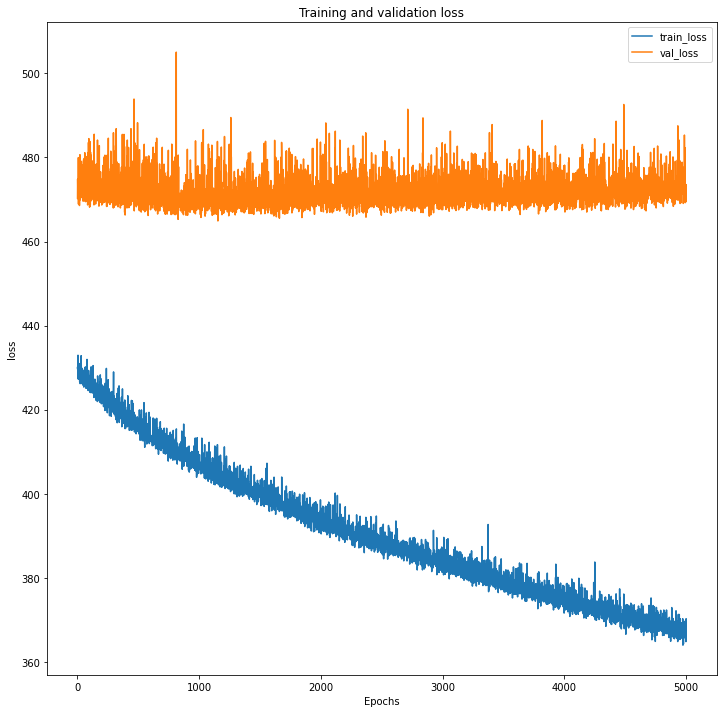

In [89]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.figure(figsize = (12,12))
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

    
plot_metric(history, 'loss')

In [90]:
new_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 320)               11520     
_________________________________________________________________
dense_81 (Dense)             (None, 160)               51360     
_________________________________________________________________
dense_82 (Dense)             (None, 80)                12880     
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 81        
Total params: 75,841
Trainable params: 75,841
Non-trainable params: 0
_________________________________________________________________


In [91]:
y_pred = new_model.predict(X_test)
y_pred

array([[1260.6351],
       [1964.9294],
       [8931.715 ],
       ...,
       [5637.718 ],
       [4770.599 ],
       [5341.036 ]], dtype=float32)

In [92]:
show_stats(y_pred)

min:  -4711.601
max:  109027.5
ptp:  113739.1
mean:  5909.7505
std:  7468.585
var:  55779760.0


In [93]:
y_pred[y_pred<0] = 11

In [94]:
true_ID = pd.read_csv('./used_car_sample_submit.csv')
true_ID['SaleID']

sub = pd.DataFrame()
sub['SaleID'] = true_ID['SaleID']
sub['price'] = y_pred
sub.to_csv("ans_nn3.csv",index=False)  

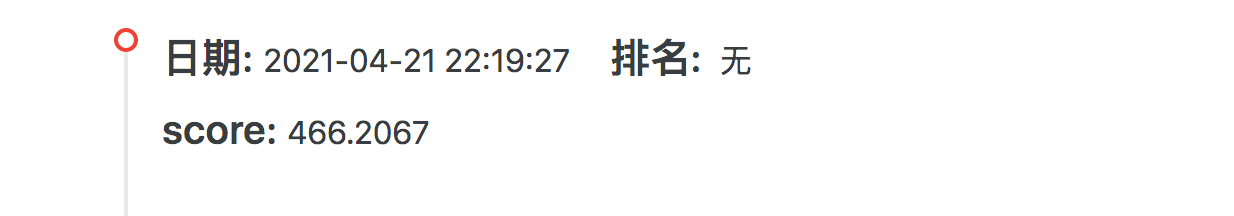